**Main Required packages** apart from basics:

statsmodels, geopandas, seaborn, xlrd, openpyxl

## LAB2. Part 2. Real Estate Price Assessment. Cleaning the data. Working with geospatial data

* Objectives: 
    + Assess the spatial distribution of housing price per sq.foot accross NYC.
    + Practice data cleaning.
    + Practice working with the geospatial datasets.
* Datasets:
    + Rolling Sales Data: Annualized Sales files display yearly sales information of properties sold in New York City.
    + Tax borough, block and lot (BBL) map, zip code map, neighborhood map.
* Skills:
    + Data cleaning, sanity and density checks.
    + Read geospatial datasets.
    + Convert non-spatial data to spatial data.
    + Spatial join.
    + Geospatial data projection.
    + Geospatial data visulization.   

In [2]:
#include packages
import pandas as pd
import geopandas as gpd #geopandas for dataframes with spatial info
from shapely.geometry import Point
import numpy as np
import matplotlib.pyplot as plt #for creating plots

import os 
import seaborn as sns #for styling the plots
import statsmodels.formula.api as smf
import warnings
import urllib.request
warnings.filterwarnings('ignore')
%matplotlib inline 

##### urllib
urllib is a package that collects several modules for working with URLs, and urllib.request for opening and reading URLs, including urllib.request.urlopen which is for open a url, urllib.request.urlretrieve: copy a network object denoted by a URL to a local file

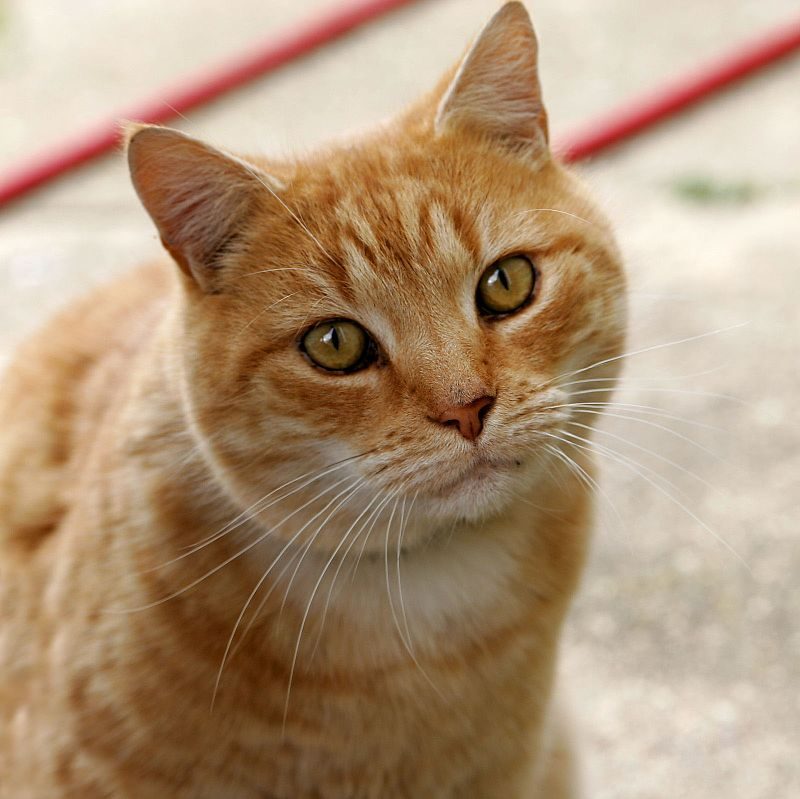

In [3]:
# an example of urllib.request.urlopen

#display image in jupyter notebook
from IPython.display import Image
# read bytes in RAM
from io import BytesIO
url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Cat03.jpg/800px-Cat03.jpg'

Image(urllib.request.urlopen(url).read())

## Data Download & Pre-processing

### Rolling sales data
##### The Department of Finance’s Rolling Sales files lists properties that sold in the last twelve-month period in New York City for all tax classes. These files include:
* sale date
* the address, zip code and tax borough, block and lot (BBL)
* building type;
* square footage;
* the price
* other characteristics

The data is provided by year and borough from 2008 to 2020. So we'll download multiple files to cover the entire city over the last decade and combine them together

Sales data could be in .xls or .xlsx format.
Instead of checking the format manually, let us just try to retrieve it in .xls first;
if a file is in .xlsx, the url does not exist, then HTTP error will be raised; we'll handle it and then try .xlsx in this case. This can also serve as an example of using exception handing in Python

In [4]:
# make sure we prepare a path to save the data
# mkdir is a unix command: make a directory under current path, add ! before it to run in jupyter notebook
if not os.path.exists('Data'):
    !mkdir Data
if not os.path.exists('Data/RollingSale'):
    !mkdir Data/RollingSale

In [5]:
# use  urllib.request.urlretrieve
# may take up to 2-3 minutes to run
for year in range(2011,2020): #for years 2011-2020
    for boro in ['manhattan','bronx','brooklyn','queens','statenisland']: #for all the boroughs

            try: # try to retrieve the file in .xls
                url = 'https://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/annualized-sales/'+\
                                                                    str(year)+'/'+str(year)+'_'+boro+'.xls'
                urllib.request.urlretrieve(url,'Data/RollingSale/'+str(year)+boro+'.xls')
                
            except urllib.error.HTTPError as e: #in case of exception (.xls does not exist), try .xlsx:
                url = 'https://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/annualized-sales/'+\
                                                                    str(year)+'/'+str(year)+'_'+boro+'.xlsx'
                urllib.request.urlretrieve(url,'Data/RollingSale/'+str(year)+boro+'.xlsx')
print('done')

done


### Clean the format

In [7]:
#As we may recall from the previous lab, we need to skip first 4 rows before the data can be uploaded properly.

Sales = pd.read_excel('./Data/RollingSale/2012manhattan.xls')
Sales

,"MANHATTAN ANNUALIZE SALE FOR YEAR 2012. All Sales From Jan 1, 2012 - Dec 31, 2012.",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20
0,Sales File as of 03/31/2013 Coop Sales Files ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Neighborhood Name and Descriptive Data is as o...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Building Class Category is based on Building C...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BOROUGH\n,NEIGHBORHOOD\n,BUILDING CLASS CATEGORY\n,TAX CLASS AT PRESENT\n,BLOCK\n,LOT\n,EASE-MENT\n,BUILDING CLASS AT PRESENT\n,ADDRESS\n,APARTMENT NUMBER\n,...,RESIDENTIAL UNITS\n,COMMERCIAL UNITS\n,TOTAL UNITS\n,LAND SQUARE FEET\n,GROSS SQUARE FEET\n,YEAR BUILT\n,TAX CLASS AT TIME OF SALE\n,BUILDING CLASS AT TIME OF SALE\n,SALE PRICE\n,SALE DATE\n
4,1,ALPHABET CITY,03 THREE FAMILY HOMES,1,377,10,,C0,356 EAST 8TH STREET,,...,3,0,3,1804,2928,1899,1,C0,0,2012-07-09 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26257,1,WASHINGTON HEIGHTS UPPER,29 COMMERCIAL GARAGES,4,2170,27,,G7,655 WEST 187 STREET,,...,0,0,0,1582,0,0,4,G7,0,2012-09-24 00:00:00
26258,1,WASHINGTON HEIGHTS UPPER,29 COMMERCIAL GARAGES,4,2170,28,,G7,657 WEST 187 STREET,,...,0,0,0,1582,0,0,4,G7,4750000,2012-09-24 00:00:00
26259,1,WASHINGTON HEIGHTS UPPER,29 COMMERCIAL GARAGES,4,2170,32,,G7,667 WEST 187 STREET,,...,0,0,0,4496,0,0,4,G7,0,2012-09-24 00:00:00
26260,1,WASHINGTON HEIGHTS UPPER,29 COMMERCIAL GARAGES,4,2246,43,,G1,270 DYCKMAN STREET,,...,0,2,2,14980,46200,1929,4,G1,4917000,2012-09-11 00:00:00


In [8]:
'''skip first four rows'''
Sales = pd.read_excel('./Data/RollingSale/2012manhattan.xls',skiprows=4)
Sales

,BOROUGH\n,NEIGHBORHOOD\n,BUILDING CLASS CATEGORY\n,TAX CLASS AT PRESENT\n,BLOCK\n,LOT\n,EASE-MENT\n,BUILDING CLASS AT PRESENT\n,ADDRESS\n,APARTMENT NUMBER\n,...,RESIDENTIAL UNITS\n,COMMERCIAL UNITS\n,TOTAL UNITS\n,LAND SQUARE FEET\n,GROSS SQUARE FEET\n,YEAR BUILT\n,TAX CLASS AT TIME OF SALE\n,BUILDING CLASS AT TIME OF SALE\n,SALE PRICE\n,SALE DATE\n
0,1,ALPHABET CITY,03 THREE FAMILY HOMES,1,377,10,,C0,356 EAST 8TH STREET,,...,3,0,3,1804,2928,1899,1,C0,0,2012-07-09
1,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,375,62,,C4,715 EAST 5TH STREET,,...,20,0,20,2426,9345,1900,2,C4,3650000,2012-09-06
2,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,376,30,,C4,274 EAST SEVENTH STREET,,...,13,0,13,2726,13002,1910,2,C4,895250,2012-10-25
3,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,377,52,,C2,271 EAST 7TH STREET,,...,5,0,5,2169,3728,1900,2,C2,0,2012-02-16
4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,387,157,,C1,619 EAST 5TH STREET,,...,40,0,40,4853,25200,1900,2,C1,10800000,2012-07-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26253,1,WASHINGTON HEIGHTS UPPER,29 COMMERCIAL GARAGES,4,2170,27,,G7,655 WEST 187 STREET,,...,0,0,0,1582,0,0,4,G7,0,2012-09-24
26254,1,WASHINGTON HEIGHTS UPPER,29 COMMERCIAL GARAGES,4,2170,28,,G7,657 WEST 187 STREET,,...,0,0,0,1582,0,0,4,G7,4750000,2012-09-24
26255,1,WASHINGTON HEIGHTS UPPER,29 COMMERCIAL GARAGES,4,2170,32,,G7,667 WEST 187 STREET,,...,0,0,0,4496,0,0,4,G7,0,2012-09-24
26256,1,WASHINGTON HEIGHTS UPPER,29 COMMERCIAL GARAGES,4,2246,43,,G1,270 DYCKMAN STREET,,...,0,2,2,14980,46200,1929,4,G1,4917000,2012-09-11


In [9]:
#check column names
print(Sales.columns)

Index(['BOROUGH\n', 'NEIGHBORHOOD\n', 'BUILDING CLASS CATEGORY\n',
       'TAX CLASS AT PRESENT\n', 'BLOCK\n', 'LOT\n', 'EASE-MENT\n',
       'BUILDING CLASS AT PRESENT\n', 'ADDRESS\n', 'APARTMENT NUMBER\n',
       'ZIP CODE\n', 'RESIDENTIAL UNITS\n', 'COMMERCIAL UNITS\n',
       'TOTAL UNITS\n', 'LAND SQUARE FEET\n', 'GROSS SQUARE FEET\n',
       'YEAR BUILT\n', 'TAX CLASS AT TIME OF SALE\n',
       'BUILDING CLASS AT TIME OF SALE\n', 'SALE PRICE\n', 'SALE DATE\n'],
      dtype='object')


In [10]:
#fix column names, excluding \n
Sales.columns = [col.replace('\n','') for col in Sales.columns]
Sales.head(5)

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,1,ALPHABET CITY,03 THREE FAMILY HOMES,1,377,10,,C0,356 EAST 8TH STREET,,...,3,0,3,1804,2928,1899,1,C0,0,2012-07-09
1,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,375,62,,C4,715 EAST 5TH STREET,,...,20,0,20,2426,9345,1900,2,C4,3650000,2012-09-06
2,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,376,30,,C4,274 EAST SEVENTH STREET,,...,13,0,13,2726,13002,1910,2,C4,895250,2012-10-25
3,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,377,52,,C2,271 EAST 7TH STREET,,...,5,0,5,2169,3728,1900,2,C2,0,2012-02-16
4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,387,157,,C1,619 EAST 5TH STREET,,...,40,0,40,4853,25200,1900,2,C1,10800000,2012-07-13


In [11]:
Sales.columns

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY',
       'TAX CLASS AT PRESENT', 'BLOCK', 'LOT', 'EASE-MENT',
       'BUILDING CLASS AT PRESENT', 'ADDRESS', 'APARTMENT NUMBER', 'ZIP CODE',
       'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS',
       'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT',
       'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE',
       'SALE PRICE', 'SALE DATE'],
      dtype='object')

In [12]:
#subset dataframe by selecting columns we're going to use
selectedNames = ['BOROUGH','BLOCK','LOT', 'BUILDING CLASS CATEGORY', 'ADDRESS', 'ZIP CODE',
                'GROSS SQUARE FEET', 'YEAR BUILT','SALE PRICE', 'SALE DATE']
Sales = Sales[selectedNames]
Sales.head()

,BOROUGH,BLOCK,LOT,BUILDING CLASS CATEGORY,ADDRESS,ZIP CODE,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE,SALE DATE
0,1,377,10,03 THREE FAMILY HOMES,356 EAST 8TH STREET,10009,2928,1899,0,2012-07-09
1,1,375,62,07 RENTALS - WALKUP APARTMENTS,715 EAST 5TH STREET,10009,9345,1900,3650000,2012-09-06
2,1,376,30,07 RENTALS - WALKUP APARTMENTS,274 EAST SEVENTH STREET,10009,13002,1910,895250,2012-10-25
3,1,377,52,07 RENTALS - WALKUP APARTMENTS,271 EAST 7TH STREET,10009,3728,1900,0,2012-02-16
4,1,387,157,07 RENTALS - WALKUP APARTMENTS,619 EAST 5TH STREET,10009,25200,1900,10800000,2012-07-13


### Merge all rolling sales data into a single dataframe

In [13]:
# get all the files from a given folder
files = os.listdir('./Data/RollingSale/')
files

['2017queens.xls',
 '2012statenisland.xls',
 '2015manhattan.xls',
 '2012manhattan.xls',
 '2018queens.xlsx',
 '2018manhattan.xlsx',
 '2011queens.xls',
 '2019statenisland.xlsx',
 '2014bronx.xls',
 '2015bronx.xls',
 '2015brooklyn.xls',
 '2015statenisland.xls',
 '2013manhattan.xls',
 '2014manhattan.xls',
 '2016queens.xls',
 '2016brooklyn.xls',
 '2018brooklyn.xlsx',
 '2014statenisland.xls',
 '2013bronx.xls',
 '2012bronx.xls',
 '2019brooklyn.xlsx',
 '2013statenisland.xls',
 '2013brooklyn.xls',
 '2018statenisland.xlsx',
 '2017bronx.xls',
 '2016bronx.xls',
 '2015queens.xls',
 '2014brooklyn.xls',
 '2016statenisland.xls',
 '2011statenisland.xls',
 '2013queens.xls',
 '2019bronx.xlsx',
 '2011brooklyn.xls',
 '2019queens.xlsx',
 '2019manhattan.xlsx',
 '2012brooklyn.xls',
 '2014queens.xls',
 '2016manhattan.xls',
 '2011manhattan.xls',
 '2012queens.xls',
 '2011bronx.xls',
 '2017brooklyn.xls',
 '2017manhattan.xls',
 '2018bronx.xlsx',
 '2017statenisland.xls']

In [15]:
#read all those files and merge into a single dataframe (assume they have the same format which is apparently the case)
#takes up to a minute to run
Sales = pd.read_excel('./Data/RollingSale/'+files[0],skiprows=4) #read the first one to set up the dataframe
Sales.columns = [name.replace('\n','') for name in Sales.columns] #fix the columns
Sales = Sales[selectedNames] #filter the columns

for file in files[1:]: #for all the files in the folder
    if '.xls' in  file: #just in case take only Excel ones (both xls and xlsx will qualify)
        df = pd.read_excel('./Data/RollingSale/'+file,skiprows=4)
        df.columns = [name.replace('\n','') for name in df.columns]
        df = df[selectedNames]
        # pd.concat: Concatenate pandas objects along rows or columns
        Sales = pd.concat([Sales,df],axis=0)

In [16]:
Sales.head() #preview the data

,BOROUGH,BLOCK,LOT,BUILDING CLASS CATEGORY,ADDRESS,ZIP CODE,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE,SALE DATE
0,4,976,10,01 ONE FAMILY DWELLINGS,21-10 81ST STREET,11370.0,1224.0,1950.0,600000,2017-04-10
1,4,976,10,01 ONE FAMILY DWELLINGS,21-10 81ST STREET,11370.0,1224.0,1950.0,750000,2017-06-16
2,4,976,11,01 ONE FAMILY DWELLINGS,21-12 81ST STREET,11370.0,1224.0,1950.0,600000,2017-04-10
3,4,976,11,01 ONE FAMILY DWELLINGS,21-12 81ST STREET,11370.0,1224.0,1950.0,730000,2017-08-23
4,4,976,15,01 ONE FAMILY DWELLINGS,21-20 81ST STREET,11370.0,1224.0,1950.0,792000,2017-07-26


In [17]:
len(Sales) #total number of records

773881

## Descriprive analsysis and data cleaning 

In [18]:
Sales.describe()

,BOROUGH,BLOCK,LOT,ZIP CODE,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE,SALE DATE
count,773881.000000,773881.000000,773881.000000,773865.000000,7.566550e+05,767854.000000,7.738810e+05,773881
mean,2.883927,4036.389453,384.327311,10777.839641,4.355976e+03,1769.972981,1.067202e+06,2015-07-24 05:24:12.479127808
min,1.000000,1.000000,1.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,2011-01-01 00:00:00
25%,1.000000,1196.000000,22.000000,10128.000000,0.000000e+00,1920.000000,0.000000e+00,2013-06-10 00:00:00
50%,3.000000,2895.000000,50.000000,11207.000000,1.170000e+03,1936.000000,3.370000e+05,2015-07-29 00:00:00
75%,4.000000,5986.000000,1002.000000,11355.000000,2.279000e+03,1965.000000,7.300000e+05,2017-09-17 00:00:00
max,5.000000,16350.000000,9139.000000,11697.000000,8.942176e+06,2020.000000,4.111112e+09,2019-12-31 00:00:00
std,1.320072,3538.164489,662.368159,884.277142,3.245737e+04,564.868687,1.302796e+07,NaN


E.g. we get an average year built for the houses 1770. Is NYC really THAT old?

Apparently as we can see all the numeric characteristics we're going to use in our analysis - zip code, size, price and year built have zero values. And accoridn to percentiles, at least 25% of the properties have missing price or size.  

So how many of those do?

In [19]:
(Sales['ZIP CODE'] == 0).sum() #looks like missing zip codes is not a common issue

2988

In [20]:
(Sales['YEAR BUILT'] == 0).sum() #nearly 10% of the records have missing year

70762

In [21]:
(Sales['GROSS SQUARE FEET'] == 0).sum() #and almost half of the records have missing size!!!

328875

In [22]:
(Sales['SALE PRICE'] == 0).sum() #missing price is also quite common

240263

In [23]:
#so if we were to quantify the average price per square foot accross the entire dataset it might be fully unreliable
Sales['SALE PRICE'].sum()/Sales['GROSS SQUARE FEET'].sum()

250.57481379656724

In [24]:
#so lets filter the zero values first 
Sales = Sales[(Sales['ZIP CODE'] > 0) & (Sales['GROSS SQUARE FEET'] > 0) & (Sales['YEAR BUILT'] > 0) & (Sales['SALE PRICE'] > 0)]

In [25]:
len(Sales) #unfortunately it wipes out nearly 2/3 of the data records

266256

In [26]:
#now if we repeate the price per square foot assessment for this sample we're getting a 10% lower number
Sales['SALE PRICE'].sum()/Sales['GROSS SQUARE FEET'].sum()

231.78240113866826

But there might be more to the story

In [27]:
Sales.describe()

,BOROUGH,BLOCK,LOT,ZIP CODE,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE,SALE DATE
count,266256.000000,266256.000000,266256.000000,266256.000000,2.662560e+05,266256.000000,2.662560e+05,266256
mean,3.390083,5231.575281,106.658445,10971.413238,7.727450e+03,1943.061520,1.791087e+06,2015-10-09 14:58:34.332071424
min,1.000000,1.000000,1.000000,10001.000000,1.000000e+00,1050.000000,1.000000e+00,2011-01-01 00:00:00
25%,3.000000,1968.000000,20.000000,10459.000000,1.413750e+03,1920.000000,3.700000e+05,2013-08-30 00:00:00
50%,4.000000,4631.000000,39.000000,11219.000000,2.000000e+03,1931.000000,5.700000e+05,2015-11-16 00:00:00
75%,4.000000,7458.000000,66.000000,11369.000000,3.000000e+03,1960.000000,9.000000e+05,2018-01-11 00:00:00
max,5.000000,16323.000000,9040.000000,11697.000000,8.942176e+06,2019.000000,4.111112e+09,2019-12-31 00:00:00
std,1.107263,3792.350171,293.794325,500.859505,4.488525e+04,33.098829,1.939670e+07,NaN


Apparently zeros were not the only issue. Even after eliminating then the new min size and price are just 1, which still does not make sense. Also the year of 1050 (450 years before Columbus) does not sound too real either. 

Besides, look at the max values - the largest property is 9M sq.feet and the most expensive - $4B worth. Clearly those number might affect the averages and they probably do (this might be why we have the average size of the properties at 7700, which does not sound like a typical house. What can we do for further sanity checks?

In [28]:
#consider the distributions. Best way to do so is by plotting histograms

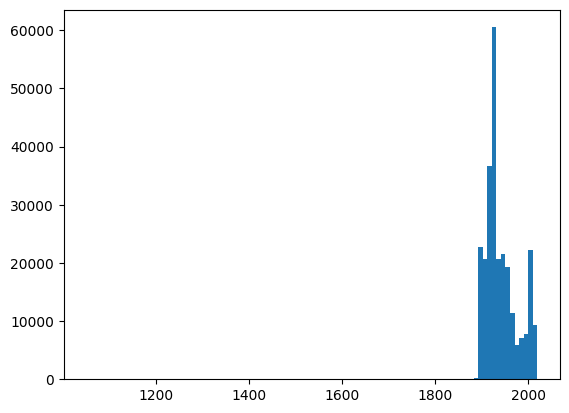

In [29]:
# for the year built 
n_bins = 100
plt.hist(Sales['YEAR BUILT'], bins=n_bins);

As we see pretty much all of the houses are built after late 1800's. And we do not have "future years". Based on that impose a "sanity" filter of YEAR>=1850.

In [30]:
(Sales['YEAR BUILT']<1850).sum() #this way we only lose 123 records

123

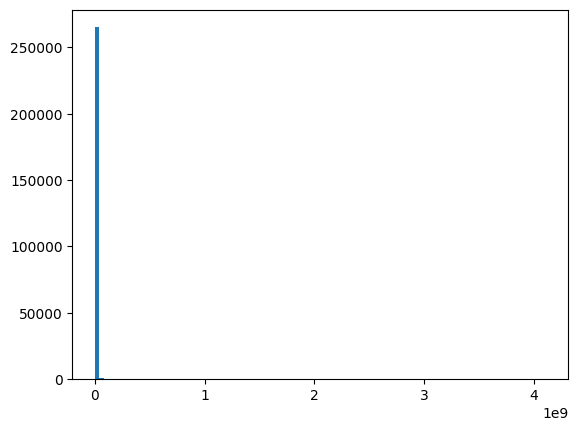

In [31]:
# for the price, if we try to plot the histogram directly, it doed not make much sense 
#as nearly everything falls in the lowest bin 
plt.hist(Sales['SALE PRICE'], bins=100);

Two things we can do about it - either limit the range by filtering the obvious outliers, or plot the histogram on the logarithmic scale

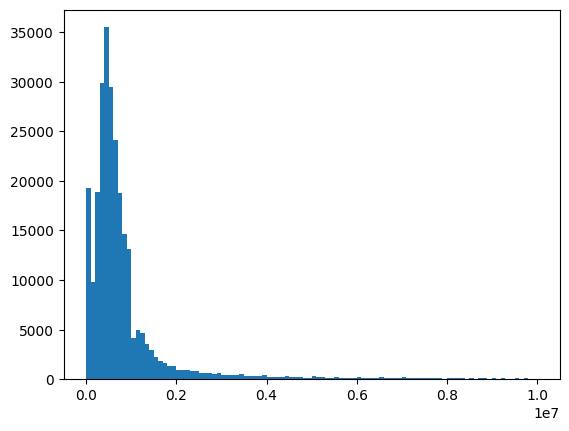

In [32]:
#take only properties worth up to 10mln; we can see majority is under 1M and vast majority falls under 2M.
plt.hist(Sales['SALE PRICE'][Sales['SALE PRICE']<1e7], bins=100);

In [33]:
#still the histogram is highly skewed and might not reflect well all the details as far as low and high values are concerned

In [34]:
def plot_loghist(x, bins): #introduce a function for plotting a log-scale histogram
  #it ensures log-scale binning and label on the original scale
    logbins = np.logspace(np.log10(x.min()),np.log10(x.max()),bins)
    plt.hist(x, bins=logbins)
    plt.xscale('log')

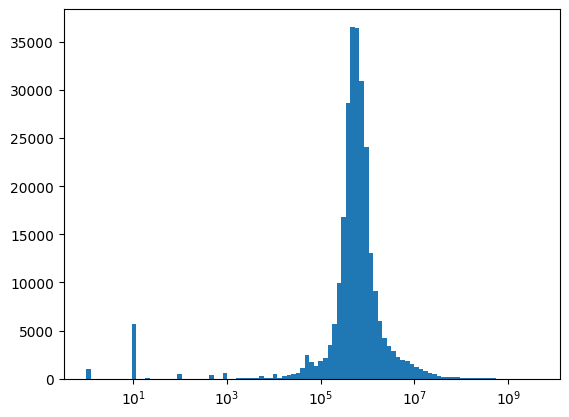

In [35]:
plot_loghist(Sales['SALE PRICE'], 100) #log-histogram of prices

In [36]:
#shows that regular distribution curve goes somewhat between 10k and 100M. We'll impose this filter

In [37]:
(Sales['SALE PRICE']<1e4).sum() #losing 9000 low outliers

8993

In [38]:
(Sales['SALE PRICE']>=5e8).sum() #losing less than 500 high outliers

47

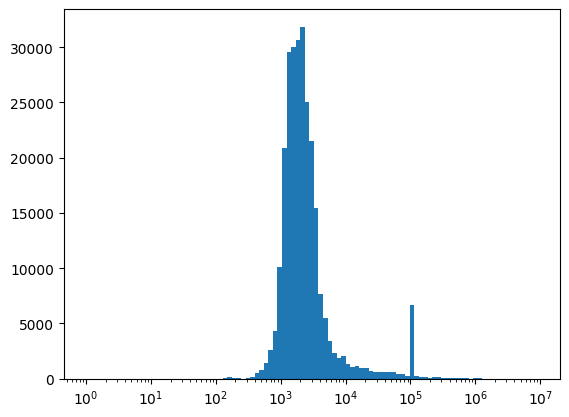

In [39]:
plot_loghist(Sales['GROSS SQUARE FEET'], 100)

for the house size the regular distribution goes between 300 and 100.000 sq.feet, 
however there is an unusual amount of around 100.000 sq feet properties, which looks like an artifact

In [40]:
(Sales['GROSS SQUARE FEET']>=1e5).sum() #the cutoff at 1e5 seems to cover this artifact, cutting nearly 8000 records

7869

In [41]:
(Sales['GROSS SQUARE FEET']<300).sum() #300ft cutoff shaves 260 low outliers

260

In [42]:
#so lets filter the zero values first 
Sales = Sales[(Sales['YEAR BUILT'] >= 1850) & (Sales['GROSS SQUARE FEET'] >=300) & (Sales['GROSS SQUARE FEET'] <1e5)
              & (Sales['SALE PRICE'] >= 1e4) & (Sales['SALE PRICE'] <= 5e8)]

In [43]:
len(Sales) #the sample shrank to quarter million records - more than 3 times from the initial size

249394

In [44]:
Sales.describe()

,BOROUGH,BLOCK,LOT,ZIP CODE,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE,SALE DATE
count,249394.000000,249394.000000,249394.000000,249394.000000,249394.000000,249394.000000,2.493940e+05,249394
mean,3.460596,5357.611414,108.569144,10997.474859,3370.719556,1941.528834,1.331203e+06,2015-11-01 15:40:14.598587136
min,1.000000,1.000000,1.000000,10001.000000,300.000000,1850.000000,1.000000e+04,2011-01-01 00:00:00
25%,3.000000,2240.000000,20.000000,10463.000000,1400.000000,1920.000000,4.000000e+05,2013-10-04 12:00:00
50%,4.000000,4737.000000,40.000000,11221.000000,1968.000000,1930.000000,5.989250e+05,2015-12-16 00:00:00
75%,4.000000,7623.000000,67.000000,11370.000000,2875.000000,1960.000000,9.250000e+05,2018-01-26 00:00:00
max,5.000000,16323.000000,9040.000000,11697.000000,99946.000000,2019.000000,3.900000e+08,2019-12-31 00:00:00
std,1.048425,3777.734846,295.850111,482.294804,6958.160557,31.731808,4.828788e+06,NaN


#### Now lets look at the categories of properties

#### Category names

In [45]:
print(Sales['BUILDING CLASS CATEGORY'].value_counts().to_string()) #get all the categories including number of their appearances

BUILDING CLASS CATEGORY
01  ONE FAMILY DWELLINGS                        45666
02  TWO FAMILY DWELLINGS                        37775
01 ONE FAMILY DWELLINGS                         25114
02 TWO FAMILY DWELLINGS                         18906
01  ONE FAMILY HOMES                            16877
02  TWO FAMILY HOMES                            14666
01 ONE FAMILY DWELLINGS                         13392
07  RENTALS - WALKUP APARTMENTS                 12703
02 TWO FAMILY DWELLINGS                         10153
03  THREE FAMILY DWELLINGS                       9877
13 CONDOS - ELEVATOR APARTMENTS                  7086
03 THREE FAMILY DWELLINGS                        4560
03  THREE FAMILY HOMES                           3789
22  STORE BUILDINGS                              3274
07 RENTALS - WALKUP APARTMENTS                   3069
14  RENTALS - 4-10 UNIT                          2424
03 THREE FAMILY DWELLINGS                        2391
07 RENTALS - WALKUP APARTMENTS                   1641
08  

Some building class categories seem duplicated by using different spelling or spacing. To fix this problem, we need to unify category names and this can be done by the unique two-digit category code we can extract 

In [46]:
# split building class category to two parts: leading 2 digits code (unique category ID) and its textual description than may vary
Sales['CATEGORY ID'] = Sales['BUILDING CLASS CATEGORY'].apply(lambda x: x[:2]) #apply a custom inline function taking first two digits of the category
Sales['BUILDING CLASS NAME'] = Sales['BUILDING CLASS CATEGORY'].apply(lambda x: x.split(' ',1)[1]).apply(lambda x:x.strip())
# also remove leading and trailing spaces

In [47]:
Sales.loc[Sales['CATEGORY ID'] == '01'].groupby(['BOROUGH','CATEGORY ID']).count()

,,BLOCK,LOT,BUILDING CLASS CATEGORY,ADDRESS,ZIP CODE,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE,SALE DATE,BUILDING CLASS NAME
BOROUGH,CATEGORY ID,,,,,,,,,,
1,01,863,863,863,863,863,863,863,863,863,863
2,01,7584,7584,7584,7584,7584,7584,7584,7584,7584,7584
3,01,17983,17983,17983,17983,17983,17983,17983,17983,17983,17983
4,01,48402,48402,48402,48402,48402,48402,48402,48402,48402,48402
5,01,26217,26217,26217,26217,26217,26217,26217,26217,26217,26217


In [48]:
#use groupby to get a list of unique categories (building classes) and use a count of any field (e.g. ADDRESS) to see how often those are occuring
Sales[['CATEGORY ID','BUILDING CLASS NAME','ADDRESS']].groupby(['CATEGORY ID','BUILDING CLASS NAME']).count()

ADDRESS
CATEGORY ID BUILDING CLASS NAME                             
01          ONE FAMILY DWELLINGS                       84172
            ONE FAMILY HOMES                           16877
02          TWO FAMILY DWELLINGS                       66834
            TWO FAMILY HOMES                           14666
03          THREE FAMILY DWELLINGS                     16828
            THREE FAMILY HOMES                          3789
04          TAX CLASS 1 CONDOS                           953
05          TAX CLASS 1 VACANT LAND                      341
06          TAX CLASS 1 - OTHER                           56
07          RENTALS - WALKUP APARTMENTS                17413
08          RENTALS - ELEVATOR APARTMENTS               2131
09          COOPS - WALKUP APARTMENTS                     80
10          COOPS - ELEVATOR APARTMENTS                   90
11          CONDO-RENTALS                                 32
            SPECIAL CONDO BILLING LOTS                    12
12          CONDOS - WALKUP APARTMENTS                   468
13          CONDOS - ELEVATOR APARTMENTS                7090
14          RENTALS - 4-10 UNIT                         3376
15          CONDOS - 2-10 UNIT RESIDENTIAL               902
16          CONDOS - 2-10 UNIT WITH COMMERCIAL UNIT        2
17          CONDO COOPS                                    4
            CONDOPS                                       10
18          TAX CLASS 3 - UNTILITY PROPERTIES              1
21          OFFICE BUILDINGS                            1837
22          STORE BUILDINGS                             4806
23          LOFT BUILDINGS                               302
25          LUXURY HOTELS                                 26
26          OTHER HOTELS                                 183
27          FACTORIES                                   1227
28          COMMERCIAL CONDOS                              4
29          COMMERCIAL GARAGES                          1627
30          WAREHOUSES                                  1603
31          COMMERCIAL VACANT LAND                        39
32          HOSPITAL AND HEALTH FACILITIES               248
33          EDUCATIONAL FACILITIES                       233
34          THEATRES                                      39
35          INDOOR PUBLIC AND CULTURAL FACILITIES        148
36          OUTDOOR RECREATIONAL FACILITIES               22
37          RELIGIOUS FACILITIES                         603
38          ASYLUMS AND HOMES                             79
39          TRANSPORTATION FACILITIES                      7
40          SELECTED GOVERNMENTAL FACILITIES               5
41          TAX CLASS 4 - OTHER                          152
42          CONDO CULTURAL/MEDICAL/EDUCATIONAL/ETC         2
43          CONDO OFFICE BUILDINGS                         1
44          CONDO PARKING                                 15
45          CONDO HOTELS                                  10
46          CONDO STORE BUILDINGS                         49

#### PRICE PER SQ FOOT PER CATEGORY

We see so many different categories of properties in the data - both, residential and commercial and even land, parking and garages! Clearly it makes no sense to talk about any average price per sq foot for all of that. So let's distinguish

In [49]:
Price_per_category = Sales[['CATEGORY ID','GROSS SQUARE FEET','SALE PRICE']].groupby(['CATEGORY ID']).sum()

In [50]:
Price_per_category['PRICE_SQFT'] = Price_per_category['SALE PRICE'] / Price_per_category['GROSS SQUARE FEET']

In [51]:
Price_per_category

,GROSS SQUARE FEET,SALE PRICE,PRICE_SQFT
CATEGORY ID,,,
01,164413416.0,64867313313,394.537836
02,183829476.0,59530959618,323.837944
03,62256797.0,18327037380,294.378096
04,1217921.0,577353856,474.048691
05,1287725.0,228265969,177.262979
06,99336.0,26133963,263.086525
07,153094027.0,51160027092,334.173894
08,94133701.0,27977191912,297.206969
09,1700300.0,234957539,138.185931


The most expensive properties are condos. While single, two and three family houses are much cheeper (per sq foot) but also differ from one another

#### Going forward let's focus on just the single family houses, which make 40% of the data.

In [52]:
SingeSales = Sales.loc[Sales['CATEGORY ID'] == '01']

In [53]:
len(SingeSales) #this leaves us with 100k records

101049

In [54]:
SingeSales.describe()

,BOROUGH,BLOCK,LOT,ZIP CODE,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE,SALE DATE
count,101049.000000,101049.000000,101049.000000,101049.000000,101049.000000,101049.000000,1.010490e+05,101049
mean,3.905759,6469.669457,72.529288,11001.911241,1627.066235,1943.936783,6.419392e+05,2015-11-19 08:12:06.776118528
min,1.000000,14.000000,1.000000,10001.000000,300.000000,1850.000000,1.000000e+04,2011-01-03 00:00:00
25%,3.000000,3689.000000,21.000000,10314.000000,1200.000000,1925.000000,3.600000e+05,2013-10-25 00:00:00
50%,4.000000,5965.000000,41.000000,11234.000000,1440.000000,1940.000000,4.875000e+05,2016-01-20 00:00:00
75%,5.000000,8847.000000,70.000000,11412.000000,1840.000000,1960.000000,6.800000e+05,2017-12-27 00:00:00
max,5.000000,16323.000000,4336.000000,11694.000000,72703.000000,2019.000000,7.710000e+07,2019-12-31 00:00:00
std,0.897559,3786.384803,149.610895,491.674879,842.525763,27.489348,1.104396e+06,NaN


apply one additional sanity check - check for properties too cheep/expensive given the size

In [55]:
SingeSales['PRICE_SQFT'] = SingeSales['SALE PRICE'] / SingeSales['GROSS SQUARE FEET']

In [56]:
SingeSales.describe() #while the average price per sq.ft look reasonable, the min and max values are way too extreme

,BOROUGH,BLOCK,LOT,ZIP CODE,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE,SALE DATE,PRICE_SQFT
count,101049.000000,101049.000000,101049.000000,101049.000000,101049.000000,101049.000000,1.010490e+05,101049,101049.000000
mean,3.905759,6469.669457,72.529288,11001.911241,1627.066235,1943.936783,6.419392e+05,2015-11-19 08:12:06.776118528,383.074886
min,1.000000,14.000000,1.000000,10001.000000,300.000000,1850.000000,1.000000e+04,2011-01-03 00:00:00,3.210273
25%,3.000000,3689.000000,21.000000,10314.000000,1200.000000,1925.000000,3.600000e+05,2013-10-25 00:00:00,241.875000
50%,4.000000,5965.000000,41.000000,11234.000000,1440.000000,1940.000000,4.875000e+05,2016-01-20 00:00:00,335.574388
75%,5.000000,8847.000000,70.000000,11412.000000,1840.000000,1960.000000,6.800000e+05,2017-12-27 00:00:00,459.595960
max,5.000000,16323.000000,4336.000000,11694.000000,72703.000000,2019.000000,7.710000e+07,2019-12-31 00:00:00,21696.861250
std,0.897559,3786.384803,149.610895,491.674879,842.525763,27.489348,1.104396e+06,NaN,287.424172


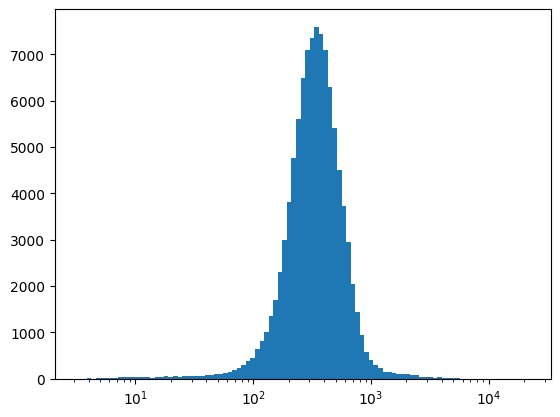

In [57]:
plot_loghist(SingeSales['PRICE_SQFT'], 100)

While it may be difficult to judge based on the histogram, let's just filter out 1% of top and 1% of the bottom outliers. We can do so using 'quantile' method (it orders the values in the increasing order and labels them by their rank divided by the total length of the sequence)

In [58]:
SingeSales['PRICE_SQFT'].quantile(0.01)

45.59276018099548

In [59]:
SingeSales['PRICE_SQFT'].quantile(0.99)

1313.966528640446

In [60]:
SingeSales = SingeSales[(SingeSales['PRICE_SQFT'] >= SingeSales['PRICE_SQFT'].quantile(0.01)) & (SingeSales['PRICE_SQFT'] <= SingeSales['PRICE_SQFT'].quantile(0.99))] #filter out the outliers

In [61]:
len(SingeSales) #as indeded we filter out around 2000 records (2% out of 100.000)

99027

In [62]:
SingeSales.describe()

,BOROUGH,BLOCK,LOT,ZIP CODE,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE,SALE DATE,PRICE_SQFT
count,99027.000000,99027.000000,99027.000000,99027.000000,99027.000000,99027.000000,9.902700e+04,99027,99027.000000
mean,3.926848,6507.727751,72.680592,11005.798621,1606.681501,1944.289759,5.748815e+05,2015-11-20 02:11:24.685994752,368.076018
min,1.000000,14.000000,1.000000,10001.000000,300.000000,1850.000000,2.000000e+04,2011-01-03 00:00:00,45.625943
25%,3.000000,3744.000000,21.000000,10314.000000,1196.000000,1925.000000,3.600000e+05,2013-10-25 00:00:00,243.722304
50%,4.000000,5993.000000,41.000000,11234.000000,1440.000000,1940.000000,4.875000e+05,2016-01-21 00:00:00,335.574388
75%,5.000000,8866.000000,70.000000,11412.000000,1830.000000,1960.000000,6.760000e+05,2017-12-27 00:00:00,456.186907
max,5.000000,16323.000000,4336.000000,11694.000000,72703.000000,2019.000000,1.293333e+07,2019-12-31 00:00:00,1313.405797
std,0.873529,3768.859075,150.200066,488.790934,755.122871,27.350803,4.178017e+05,NaN,178.544887


### Spatial filtering and Geopandas

Now once done with clearning numeric values, lets also perform spatial cleaning, by leaving only those zip codes than actually belong to NYC

In [63]:
# download zipcode map
url = 'https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip'
# alternative url
# url = 'https://github.com/CUSP2020PUI/Data/raw/master/ZIPCODE.zip'
urllib.request.urlretrieve(url,'Data/ZIPCODE.zip')

('Data/ZIPCODE.zip', <http.client.HTTPMessage at 0x16dc919d0>)

In [64]:
#it comes in the zip archive, so use zipfile module to extract it
import zipfile
with zipfile.ZipFile('Data/ZIPCODE.zip', 'r') as zip_ref:
    zip_ref.extractall('Data/ZIPCODE')

In [65]:
os.listdir('./Data/ZIPCODE') #check the filename for the shapefile

['ZIP_CODE_040114.shp.xml',
 'ZIP_CODE_040114.prj',
 'ZIP_CODE_040114.sbn',
 'ZIP_CODE_040114.dbf',
 'ZIP_CODE_040114.shp',
 'ZIP_CODE_040114.sbx',
 'ZIP_CODE_040114.shx']

In [66]:
#load the resulting shapefile using geopandas 
zipcode = gpd.read_file('./Data/ZIPCODE/ZIP_CODE_040114.shp')
zipcode.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.252 188138.380, 1038141.936 ..."
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.713 186926.440, 1002314.243 ..."
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.276 183696.338, 1011373.584 ..."
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.365 183617.613, 996522.848 18..."
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.113 176307.496, 992042.798 17..."


#### Geopandas

Geopandas dataframe is pretty much like pandas, but it also has the spetial 'geometry' field which supplies a geometry shape to each record 

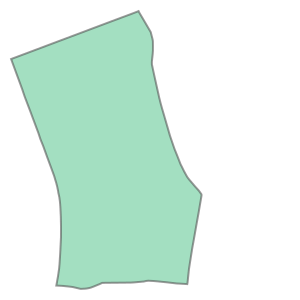

In [67]:
#It also overloads some methods, e.g. accessing the geometry field value would now visualize it by default
zipcode.geometry[0]

In [68]:
zipcode.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<Axes: >

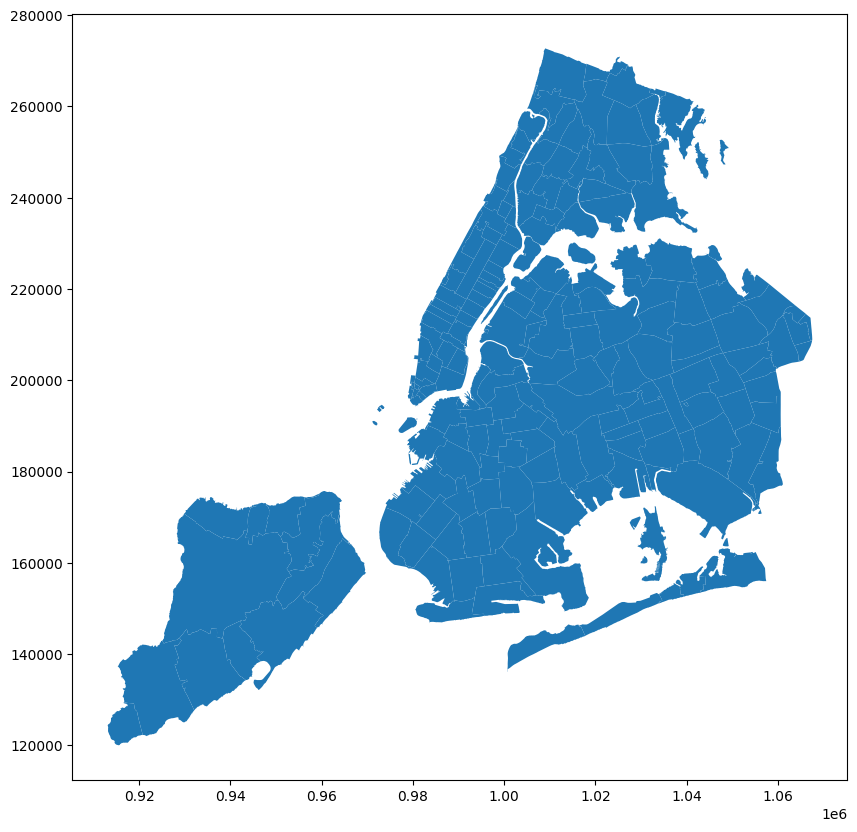

In [69]:
#and if we want to plot the entire shapefile
zipcode.plot(figsize=(10,10),aspect='equal')
#map of zip code areas in NYC

In [70]:
#and this is the list of all unique zip codes within the city
zipcode['ZIPCODE'].unique()

array(['11436', '11213', '11212', '11225', '11218', '11226', '11219',
       '11210', '11230', '11204', '10471', '10470', '10466', '10467',
       '10463', '10475', '10464', '10469', '10468', '10458', '10034',
       '10033', '10462', '10040', '10453', '10465', '10461', '10457',
       '10460', '10032', '10452', '10456', '10472', '10031', '10039',
       '10459', '10451', '10473', '10030', '10027', '10474', '10455',
       '10037', '10024', '10454', '10026', '10035', '10048', '10025',
       '11357', '10029', '00083', '11356', '11359', '11360', '11105',
       '10128', '10023', '11363', '10028', '11354', '11102', '11370',
       '10021', '11358', '11362', '10044', '11369', '11103', '11106',
       '11368', '11377', '11355', '11101', '11364', '10018', '10020',
       '11005', '10017', '10001', '10011', '10016', '11104', '11109',
       '10010', '11367', '10014', '10003', '11222', '10002', '11378',
       '10009', '10012', '10013', '10007', '11237', '11385', '10038',
       '11206', '100

In [71]:
# we see the field is textual; so convert it to numeric (int)
zipcode['ZIPCODE'] = zipcode['ZIPCODE'].astype(int)
NYC_zipcode = zipcode['ZIPCODE'].unique()

In [72]:
NYC_zipcode

array([11436, 11213, 11212, 11225, 11218, 11226, 11219, 11210, 11230,
       11204, 10471, 10470, 10466, 10467, 10463, 10475, 10464, 10469,
       10468, 10458, 10034, 10033, 10462, 10040, 10453, 10465, 10461,
       10457, 10460, 10032, 10452, 10456, 10472, 10031, 10039, 10459,
       10451, 10473, 10030, 10027, 10474, 10455, 10037, 10024, 10454,
       10026, 10035, 10048, 10025, 11357, 10029,    83, 11356, 11359,
       11360, 11105, 10128, 10023, 11363, 10028, 11354, 11102, 11370,
       10021, 11358, 11362, 10044, 11369, 11103, 11106, 11368, 11377,
       11355, 11101, 11364, 10018, 10020, 11005, 10017, 10001, 10011,
       10016, 11104, 11109, 10010, 11367, 10014, 10003, 11222, 10002,
       11378, 10009, 10012, 10013, 10007, 11237, 11385, 10038, 11206,
       10006, 11412, 10005, 11251, 10004, 11411, 11201, 11205, 11208,
       11207, 11413, 11217, 11238, 11231, 11422, 11420, 11417, 11215,
       11232, 11430, 11203, 11239, 11236, 11220, 10301, 10303, 11234,
       10302, 11693,

In [73]:
SingeSales = SingeSales[SingeSales['ZIP CODE'].isin(NYC_zipcode)]

In [74]:
len(SingeSales) #we've only lost 9 more records

99018

In [75]:
SingeSales.head()

,BOROUGH,BLOCK,LOT,BUILDING CLASS CATEGORY,ADDRESS,ZIP CODE,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE,SALE DATE,CATEGORY ID,BUILDING CLASS NAME,PRICE_SQFT
0,4,976,10,01 ONE FAMILY DWELLINGS,21-10 81ST STREET,11370.0,1224.0,1950.0,600000,2017-04-10,01,ONE FAMILY DWELLINGS,490.196078
1,4,976,10,01 ONE FAMILY DWELLINGS,21-10 81ST STREET,11370.0,1224.0,1950.0,750000,2017-06-16,01,ONE FAMILY DWELLINGS,612.745098
2,4,976,11,01 ONE FAMILY DWELLINGS,21-12 81ST STREET,11370.0,1224.0,1950.0,600000,2017-04-10,01,ONE FAMILY DWELLINGS,490.196078
3,4,976,11,01 ONE FAMILY DWELLINGS,21-12 81ST STREET,11370.0,1224.0,1950.0,730000,2017-08-23,01,ONE FAMILY DWELLINGS,596.405229
4,4,976,15,01 ONE FAMILY DWELLINGS,21-20 81ST STREET,11370.0,1224.0,1950.0,792000,2017-07-26,01,ONE FAMILY DWELLINGS,647.058824


### Temporal analysis. Does price per sq. foot change over time?

In [76]:
SingeSales['SALE YEAR']=pd.DatetimeIndex(SingeSales['SALE DATE']).year

In [77]:
SalesYear = SingeSales.groupby(['SALE YEAR']).agg({'ADDRESS':'count','SALE PRICE':'sum','GROSS SQUARE FEET':'sum'})
SalesYear['PriceperSQFT'] = SalesYear['SALE PRICE'] / SalesYear['GROSS SQUARE FEET']

In [78]:
SalesYear

,ADDRESS,SALE PRICE,GROSS SQUARE FEET,PriceperSQFT
SALE YEAR,,,,
2011,7750,3698759502,12957452.0,285.454231
2012,8773,4304955738,14912657.0,288.677983
2013,10249,5161345675,17207544.0,299.946679
2014,10488,5551955922,17550008.0,316.350621
2015,11699,6572735025,18335790.0,358.464785
2016,12290,7198027319,20223931.0,355.916331
2017,13135,8151778687,20018602.0,407.210188
2018,12733,8320365763,19578071.0,424.983941
2019,11901,7956391605,18297794.0,434.827915


<Axes: xlabel='SALE YEAR'>

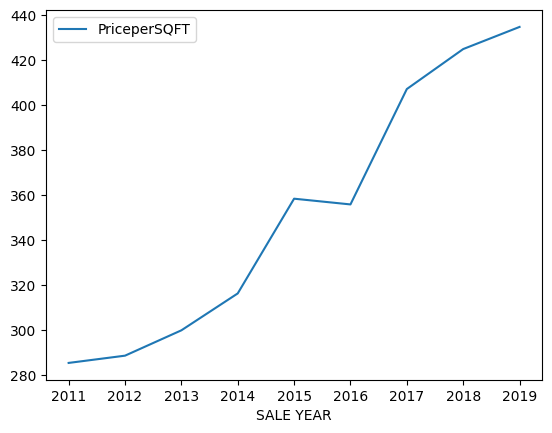

In [79]:
SalesYear.plot(y = 'PriceperSQFT', use_index = True)

So we can see a significant increase in the price per sq. foot from year to year - over 50% over the entire period. Perhaps would not be appropriate to consider prices of houses sold during different years within the same analysis (unless we somehow control/normalize for the sale year). Going forward consider only 3 most recent years 2017-2019 which saw relatively moderate increase wihtin 7% overall as compared to previous years.

In [80]:
SingleSalesRecent = SingeSales[SingeSales['SALE YEAR']>=2017]

In [81]:
SingleSalesRecent.reset_index(inplace=True,drop=True)
SingleSalesRecent.describe()

,BOROUGH,BLOCK,LOT,ZIP CODE,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE,SALE DATE,PRICE_SQFT,SALE YEAR
count,37769.000000,37769.000000,37769.000000,37769.000000,37769.000000,37769.000000,3.776900e+04,37769,37769.000000,37769.000000
mean,3.941486,6559.033202,74.625937,10984.051471,1532.856761,1945.154836,6.467880e+05,2018-06-25 18:29:42.604781568,432.380384,2017.967328
min,1.000000,15.000000,1.000000,10001.000000,300.000000,1850.000000,2.000000e+04,2017-01-03 00:00:00,45.787546,2017.000000
25%,3.000000,3736.000000,21.000000,10314.000000,1160.000000,1925.000000,4.250000e+05,2017-09-26 00:00:00,302.734375,2017.000000
50%,4.000000,5966.000000,42.000000,11234.000000,1378.000000,1940.000000,5.550000e+05,2018-06-21 00:00:00,401.234568,2018.000000
75%,5.000000,9006.000000,71.000000,11412.000000,1728.000000,1960.000000,7.650000e+05,2019-03-28 00:00:00,532.094595,2019.000000
max,5.000000,16323.000000,4328.000000,11694.000000,12720.000000,2019.000000,1.160500e+07,2019-12-31 00:00:00,1313.271605,2019.000000
std,0.891823,3826.558050,155.741961,496.801575,653.779972,27.859913,4.268685e+05,NaN,187.508974,0.813524


### Spatial analysis. Average price per sq.foot per zipcode

In [82]:
#group sales by zip code
SalesZipcode = SingleSalesRecent.groupby(['ZIP CODE']).agg({'ADDRESS':'count','SALE PRICE':'sum','GROSS SQUARE FEET':'sum'})
SalesZipcode['PriceperSQFT'] = SalesZipcode['SALE PRICE'] / SalesZipcode['GROSS SQUARE FEET']

In [83]:
SalesZipcode.head()

,ADDRESS,SALE PRICE,GROSS SQUARE FEET,PriceperSQFT
ZIP CODE,,,,
10001.0,1,5500000,4290.0,1282.051282
10009.0,3,16700000,18880.0,884.533898
10011.0,1,2421900,3935.0,615.476493
10013.0,2,10107000,8700.0,1161.724138
10014.0,2,7800000,10203.0,764.481035


We see some zip codes with just a handful of sales. And high prices, but perhaps their statistics is unreliable for our analysis as influenced by just a handful of observations

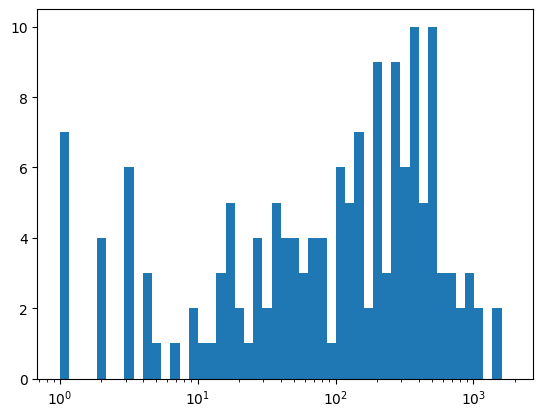

In [84]:
#records per zip code
plot_loghist(SalesZipcode['ADDRESS'],bins=50);

In [85]:
#how 
sum(SalesZipcode['ADDRESS']>=20)

121

In [86]:
SalesZipcode=SalesZipcode.loc[SalesZipcode['ADDRESS']>=20]

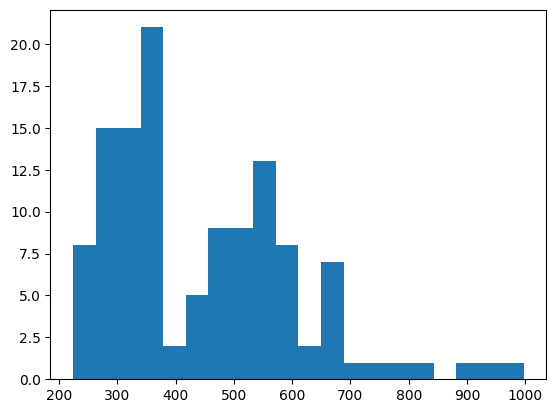

In [87]:
#distribution of price per sq.foot
plt.hist(SalesZipcode['PriceperSQFT'],bins=20);

## Geospatial dataset

#### merge with zipcode shapefile
shapefile(.shp) is another geospatial data format. Please note that .shp file always come together with .shx and .dbj files, and it cannot be readable with out its mandatory supportive files. 

In [88]:
zipcode.head(2)

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.252 188138.380, 1038141.936 ..."
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.713 186926.440, 1002314.243 ..."


In [89]:
#merge price data with the zip code shapes into a new geopandas dataframe
SalesGeo = zipcode.merge(SalesZipcode,left_on='ZIPCODE',right_on='ZIP CODE',how='left')

<Axes: >

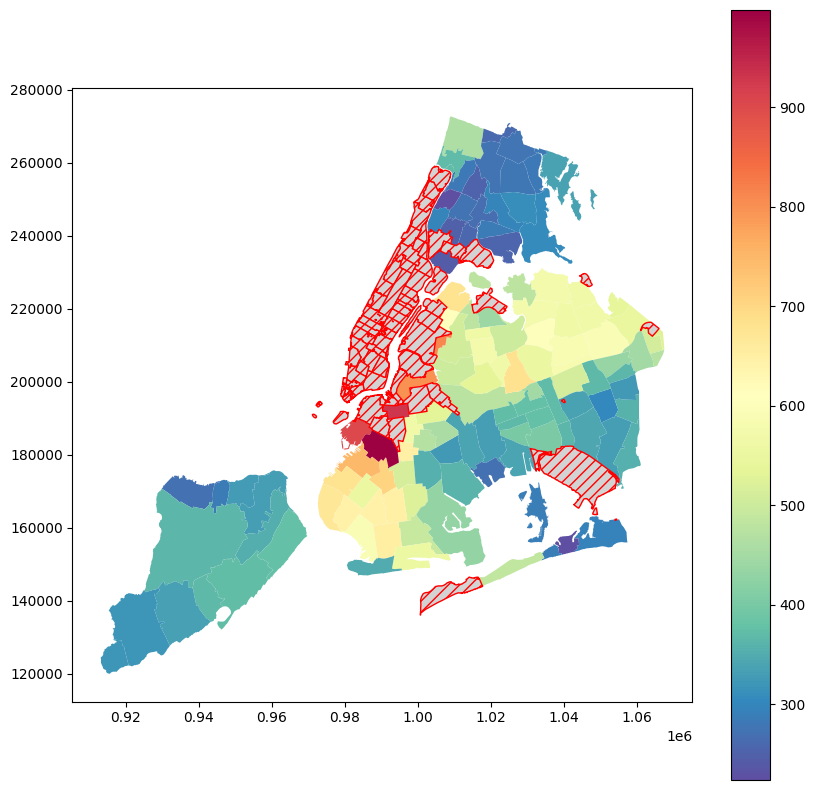

In [90]:
#plot the spatial distribution of sale price normalized by gross square feet
SalesGeo.plot(column='PriceperSQFT',colormap='Spectral_r',legend=True,markersize=0.01,figsize=(10,10),missing_kwds={
                "color": "lightgrey", ## what to do with missing values
                "edgecolor": "red",
                "hatch": "///",
                "label": "Missing values",
                },)

In [91]:
#but what do the X-Y labels mean here?
SalesGeo.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

zipcode map is projected to EPSG 2263, which is a local coordinate system that provides a high degree of accuracy and balances size and shape well. x, y axis in the previous plot is the coordinate in this projection system, in feet

### How to visualize in a different coordinate system, like latitude-longitude?

#### Different coordinate systems

All spatial data is created in some coordinate system, whether it is points, lines, polygons, rasters, or annotation. The coordinates themselves can be specified in many different ways, such as decimal degrees, feet, meters, or kilometers—in fact, any form of measurement can be used as a coordinate system. Data is defined in both horizontal and vertical coordinate systems. Horizontal coordinate systems locate data across the surface of the earth, and vertical coordinate systems locate the relative height or depth of data.

Horizontal coordinate systems can be of three types: geographic, projected, and local. You can find out what coordinate system your data is in by examining the layer's properties. Geographic coordinate systems (GCS) most commonly have units in decimal degrees measuring degrees of longitude (x-coordinates) and degrees of latitude (y-coordinates). The location of data is expressed as positive or negative numbers: positive x- and y-values for north of the equator and east of the prime meridian, and negative values for south of the equator and west of the prime meridian.

Spatial data can also be expressed using projected coordinate systems (PCS). Coordinates are expressed using linear measurements rather than angular degrees. Finally, some data may be expressed in a local coordinate system with a false origin (0, 0 or other values) in an arbitrary location that can be anywhere on earth. Local coordinate systems are often used for large-scale (small area) mapping. The false origin may be aligned to a known real-world coordinate or not, but for the purposes of data capture, bearings and distances may be measured using the local coordinate system rather than global coordinates. Local coordinate systems are usually expressed in feet or meters. 

Source: https://pro.arcgis.com/en/pro-app/help/mapping/properties/coordinate-systems-and-projections.htm

Convert geographic coordinate systems to local coordinate systems is "projection". Local coordinate systems varies with location, for NYC, we usually choose epsg: 2263 which is in feet. epsg 4326 refers to WGS84, which is the most commonly used geographic coordinate systems. Generally speaking, all latitude and longitude are recorded in epsg:4326.

When you are working on multiple geospatial datasets, always make sure that they are in the same coordinate system.

Text(0.5, 1.0, 'Distribution of Housing Price per SQFT in NYC, CRS: EPSG 2263')

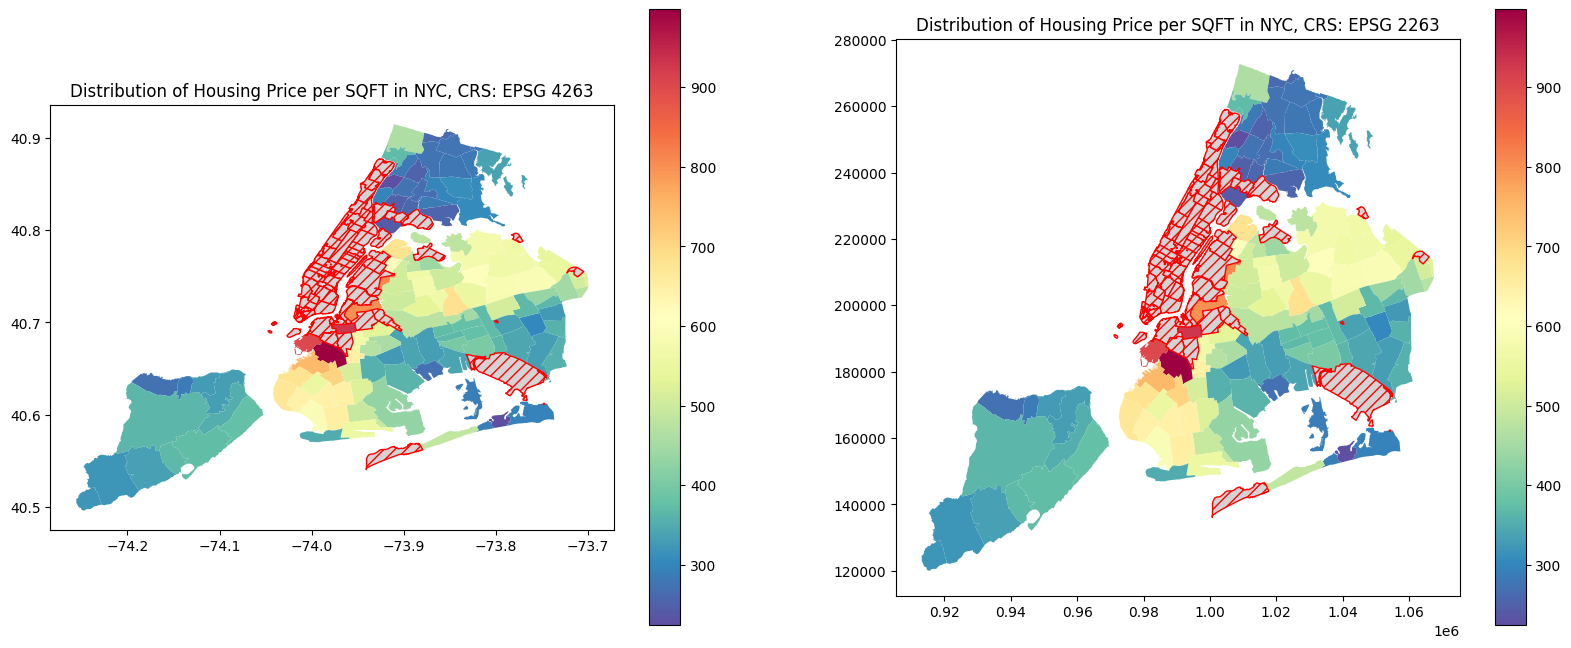

In [92]:
'''plot the spatial distribution of sale price normalized by gross square feet'''
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(20,8))
SalesGeo.to_crs({'init': 'epsg:4326'}).plot(ax=ax[0],column='PriceperSQFT',
                                            colormap='Spectral_r',legend=True,
                                            missing_kwds={
                                                            "color": "lightgrey",
                                                            "edgecolor": "red",
                                                            "hatch": "///",
                                                            "label": "Missing values",
                                                            },)
ax[0].set_aspect('equal')
ax[0].set_title('Distribution of Housing Price per SQFT in NYC, CRS: EPSG 4263',fontsize=12) 
SalesGeo.to_crs({'init': 'epsg:2263'}).plot(ax=ax[1],column='PriceperSQFT',
                                            colormap='Spectral_r',legend=True,
                                            missing_kwds={
                                                            "color": "lightgrey",
                                                            "edgecolor": "red",
                                                            "hatch": "///",
                                                            "label": "Missing values",
                                                            },)
ax[1].set_title('Distribution of Housing Price per SQFT in NYC, CRS: EPSG 2263',fontsize=12) 

### Analysis housing sale price at neighborhood level

Neighborhood refers to Neighborhood Tabulation Areas (NTAs), which created to project populations at a small area level. However, proerty transaction data lacks neighborhood information. To assign each transaction record into its neighborhood, we need to use spatial join method. Besides, sales data does not include location information like latitude and longitude, but records each property's BBL information. Borough-Block-Lot (BBL) identifies the location of buildings or properties, we can merge BBL data with Primary Land Use Tax Lot Output(PLUTO), an extensive land use and geographic data at the tax lot level, to access the exact coordinate information, then join spatially with the neighborhood map.

Spatial join is getting attributes from one layer and transferring them into another layer based on their spatial relationship is something you most likely need to do on a regular basis. Geopandas sjoin has two key arguments: 'how' and 'op'. 'how' refers to the type of join:

    + left: use keys from left_df; retain only left_df geometry column

    + right: use keys from right_df; retain only right_df geometry column

    + inner: use intersection of keys from both dfs; retain only left_df geometry column
which is same as dataframe merge in pandas.  The op argument specifies how geopandas decides whether or not to join the attributes of one object to another. There are three different join options as follows:

    + intersects: The attributes will be joined if the boundary and interior of the object intersect in any way with the boundary and/or interior of the other object.

    + within: The attributes will be joined if the object’s boundary and interior intersect only with the interior of the other object (not its boundary or exterior).

    + contains: The attributes will be joined if the object’s interior contains the boundary and interior of the other object and their boundaries do not touch at all.

In [110]:
BBL = pd.read_csv('BBL.csv', on_bad_lines='skip')
BBL = BBL[['borough', 'block', 'lot','latitude', 'longitude']]
BBL.head()

,borough,block,lot,latitude,longitude
0,BX,2587,22,40.801976,-73.911062
1,MN,135,14,40.714522,-74.007988
2,BK,7087,5,40.601540,-73.972941
3,QN,2930,10,40.721815,-73.884945
4,MN,736,22,40.756560,-73.995102


In [94]:
'''borough, block, lot are not unique values. For example, there are 9772 lots are numbered as lot 46'''
BBL.loc[BBL['lot']==46]

,borough,block,lot,latitude,longitude
284,BK,4666,46,40.655246,-73.920996
290,BK,1829,46,40.684148,-73.944531
315,BK,176,46,40.688454,-73.988007
324,BK,3622,46,40.656759,-73.910683
365,QN,1889,46,40.740951,-73.864935
...,...,...,...,...,...
857658,BK,4346,46,40.657268,-73.890438
857730,BX,5543,46,40.827735,-73.824448
857755,QN,12736,46,40.694572,-73.741131
857780,BK,8226,46,40.643015,-73.896313


In [95]:
'''but if we loc dataframe by borough, block, and lot together, only one row is returned. Thus, to merge BBL 
coordinate dataframe to sales dataframe, we need to use three columns as the merge-key'''
BBL.loc[(BBL['borough']=='BK')&(BBL['block']==834)&(BBL['lot']==46)]

,borough,block,lot,latitude,longitude
124054,BK,834,46,40.637972,-74.007347


In [96]:
BoroCode = {'BK':'3', 'QN':'4', 'BX':'2', 'SI':'5', 'MN':'1'}
BBL['borough'] = BBL.borough.apply(lambda x: BoroCode[x] if x in BoroCode else np.nan)
'''drop rows which have nan value in any column'''
BBL.dropna(inplace=True)

In [97]:
'''before merge, we need to convert  borough, block, lot in BBL dataframe and residenceSale dataframe to 
same type: string. '''

#convert BBL column names same as residenceSale to make further steps easier
BBL.columns = [col.upper() for col in BBL.columns]
BBL['BOROUGH'] = BBL['BOROUGH'].astype('str')
BBL['BLOCK'] = BBL['BLOCK'].astype('str')
BBL['LOT'] = BBL['LOT'].astype('str')
SingeSales['BOROUGH'] = SingeSales['BOROUGH'].astype('str')
SingeSales['BLOCK'] = SingeSales['BLOCK'].astype('str')
SingeSales['LOT'] = SingeSales['LOT'].astype('str')
SingeSalesLatLon = BBL.merge(SingeSales,on=['BOROUGH','BLOCK','LOT'],how='right')
'''or we can do:'''
# residenceSaleLatLon = BBL.merge(residenceSale,right_on=['BOROUGH','BLOCK','LOT'],\
#                                 left_on=['BOROUGH','BLOCK','LOT'],how='right')

SingeSalesLatLon.dropna(inplace=True)

In [98]:
SingeSalesLatLon.head()

,BOROUGH,BLOCK,LOT,LATITUDE,LONGITUDE,BUILDING CLASS CATEGORY,ADDRESS,ZIP CODE,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE,SALE DATE,CATEGORY ID,BUILDING CLASS NAME,PRICE_SQFT,SALE YEAR
0,4,976,10,40.770538,-73.889334,01 ONE FAMILY DWELLINGS,21-10 81ST STREET,11370.0,1224.0,1950.0,600000,2017-04-10,01,ONE FAMILY DWELLINGS,490.196078,2017
1,4,976,10,40.770538,-73.889334,01 ONE FAMILY DWELLINGS,21-10 81ST STREET,11370.0,1224.0,1950.0,750000,2017-06-16,01,ONE FAMILY DWELLINGS,612.745098,2017
2,4,976,11,40.770492,-73.889324,01 ONE FAMILY DWELLINGS,21-12 81ST STREET,11370.0,1224.0,1950.0,600000,2017-04-10,01,ONE FAMILY DWELLINGS,490.196078,2017
3,4,976,11,40.770492,-73.889324,01 ONE FAMILY DWELLINGS,21-12 81ST STREET,11370.0,1224.0,1950.0,730000,2017-08-23,01,ONE FAMILY DWELLINGS,596.405229,2017
4,4,976,15,40.770297,-73.889291,01 ONE FAMILY DWELLINGS,21-20 81ST STREET,11370.0,1224.0,1950.0,792000,2017-07-26,01,ONE FAMILY DWELLINGS,647.058824,2017


In [99]:
'''make points from given latitudes and longitudes'''
geometry = [Point(xy) for xy in zip(SingeSalesLatLon.LONGITUDE, SingeSalesLatLon.LATITUDE)]

geoSingeSalesLatLon = gpd.GeoDataFrame(SingeSalesLatLon[['SALE PRICE','GROSS SQUARE FEET']],
                                    geometry=geometry,crs={'init': 'epsg:4326'})
'''crs={'init': 'epsg:4326'} is define the coordinate system when generating a new geodataframe'''


"crs={'init': 'epsg:4326'} is define the coordinate system when generating a new geodataframe"

In [100]:
# read neighborhood map
url = 'https://data.cityofnewyork.us/api/geospatial/cpf4-rkhq?method=export&format=GeoJSON'
# alternative url
# url = 'https://github.com/CUSP2020PUI/Data/raw/master/neighborhood.geojson'
urllib.request.urlretrieve(url,'Data/neighborhood.geojson')
neighborhood = gpd.read_file('Data/neighborhood.geojson')
neighborhood = neighborhood[['ntacode','geometry']]
neighborhood.head()

,ntacode,geometry
0,QN08,"MULTIPOLYGON (((-73.75205 40.70523, -73.75174 ..."
1,BX28,"MULTIPOLYGON (((-73.88705 40.88435, -73.88705 ..."
2,QN55,"MULTIPOLYGON (((-73.80577 40.68293, -73.80552 ..."
3,BK50,"MULTIPOLYGON (((-73.88834 40.64671, -73.88835 ..."
4,BX41,"MULTIPOLYGON (((-73.89561 40.85457, -73.89662 ..."


In [101]:
'''spatial join sales data to neighborhood map, 
and calculate the average housing sales price per sqft at each neighborhood'''
ResidenceSaleNeighborhood = gpd.sjoin(geoSingeSalesLatLon,neighborhood,op='within',how='right')
# ResidenceSaleNeighborhood = ResidenceSaleNeighborhood[['ntacode','SALE PRICE','GROSS SQUARE FEET']]
'''group by neighborhood ntacode to get sum of sale price and gross square feet of transacted properties, and
properties transaction times in each neighborhood. Groupby function cannot keep geometry information, so we need to
merge the grouped dataframe with neighborhood map again'''
ResidenceSaleNeighborhood['SaleTimes'] = 1
ResidenceSaleNeighborhood = ResidenceSaleNeighborhood.groupby(['ntacode']).\
                            agg({'SALE PRICE':'sum','GROSS SQUARE FEET':'sum','SaleTimes':'sum'}).reset_index()
ResidenceSaleNeighborhood = neighborhood.merge(ResidenceSaleNeighborhood,on='ntacode',how='left')
ResidenceSaleNeighborhood['PriceperSQFT'] = ResidenceSaleNeighborhood['SALE PRICE'] / ResidenceSaleNeighborhood['GROSS SQUARE FEET']

In [102]:
ResidenceSaleNeighborhood

,ntacode,geometry,SALE PRICE,GROSS SQUARE FEET,SaleTimes,PriceperSQFT
0,QN08,"MULTIPOLYGON (((-73.75205 40.70523, -73.75174 ...",1.186855e+09,4524772.0,3207,262.301636
1,BX28,"MULTIPOLYGON (((-73.88705 40.88435, -73.88705 ...",3.932189e+07,150050.0,88,262.058600
2,QN55,"MULTIPOLYGON (((-73.80577 40.68293, -73.80552 ...",9.669060e+08,3018693.0,2334,320.306182
3,BK50,"MULTIPOLYGON (((-73.88834 40.64671, -73.88835 ...",3.081349e+08,1044566.0,799,294.988476
4,BX41,"MULTIPOLYGON (((-73.89561 40.85457, -73.89662 ...",2.707596e+07,125307.0,66,216.077019
...,...,...,...,...,...,...
190,BK93,"MULTIPOLYGON (((-73.88829 40.64672, -73.88829 ...",0.000000e+00,0.0,1,NaN
191,BK73,"MULTIPOLYGON (((-73.95814 40.72440, -73.95772 ...",4.385317e+07,61862.0,24,708.887023
192,MN28,"MULTIPOLYGON (((-73.98237 40.70554, -73.98246 ...",3.200000e+06,3680.0,1,869.565217
193,BK40,"MULTIPOLYGON (((-73.98017 40.66115, -73.98021 ...",1.580363e+08,224376.0,141,704.336756


In [103]:
# eliminate average sale price records in neighborhoods where transaction times below 20
ResidenceSaleNeighborhood.loc[ResidenceSaleNeighborhood['SaleTimes']<20,'PriceperSQFT'] = np.nan

<Axes: >

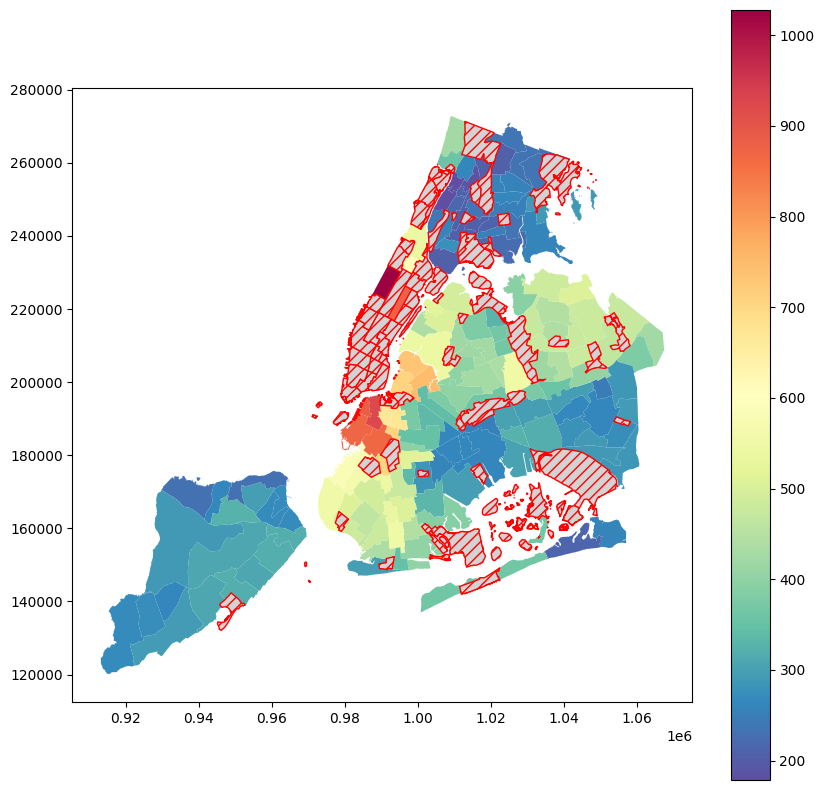

In [104]:
# ResidenceSaleNeighborhood = ResidenceSaleNeighborhood.loc[ResidenceSaleNeighborhood['SaleTimes']>20]

ResidenceSaleNeighborhood.to_crs({'init': 'epsg:2263'}).plot(column='PriceperSQFT',
                                            colormap='Spectral_r',legend=True,markersize=0.01,
                                            missing_kwds={
                                                            "color": "lightgrey",
                                                            "edgecolor": "red",
                                                            "hatch": "///",
                                                            "label": "Missing values",
                                                            },
                                            figsize=(10,10))

# Homework. Part 2.

#### Task 1. 
Repeat the temporal analysis for the two-family houses producing temporal trend (price per sq. foot per year).

In [105]:
# your code here

#### Task 2. 
Compute average price per square foot of the one, two and three family houses per borough. Visualize as three bar plots (one per each type of houses). 

EXTRACREDIT: Find a way to output the results as a table, rows - boroughs, columns - type of the house and a bar plot with one group per each borough, three bars within each group - one, two, three family house. Supply a legend.

In [106]:
# your code here

#### Task 3
Visualize the average size (sq.foot) of the a single family house per zip code area. Exclude zip code areas having less than 20 houses sold

In [107]:
# your code here

#### Task 4. 
Plot 10 zip codes with highest and 10 with the lowest single family house prices per SQFT in NYC. Use two different colors for high and low price areas and third color for the rest of zip code areas. As before exclude those with <20 transactions (shade them as before). Provide legend.

(905410.7560429365, 1075212.5382562787, 112386.35181947277, 280345.45402395504)

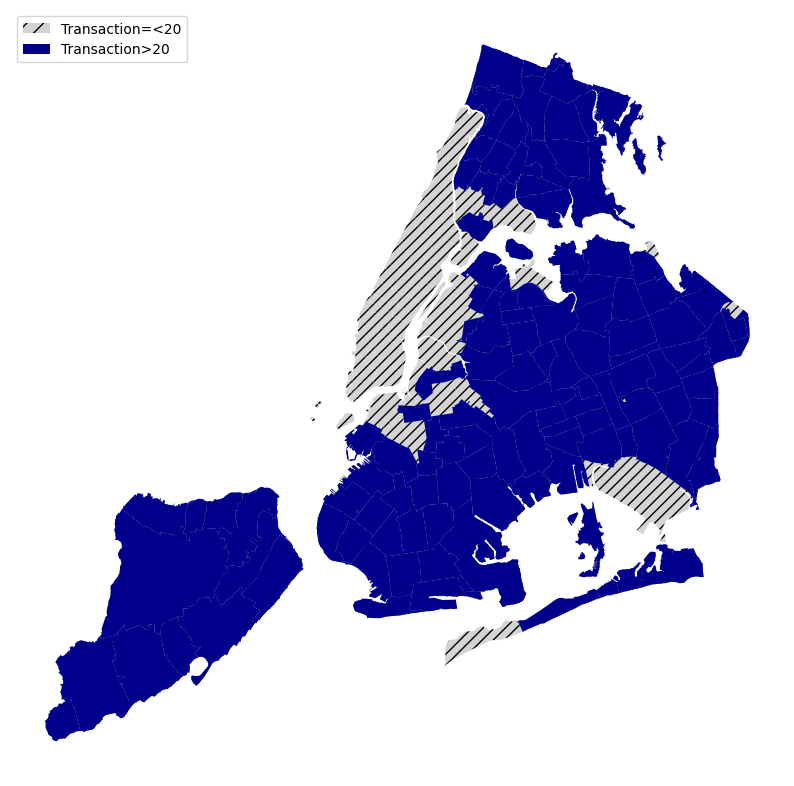

In [108]:
# HINT: example on categorizal visualization: zipcodes having more/less than 20 transactions
import matplotlib.patches as mpatches
fig,ax = plt.subplots(figsize=(10,10))
SalesGeo.plot(facecolor='lightgrey',hatch='///',ax=ax)
SalesGeo.loc[SalesGeo['ADDRESS']>20].plot(facecolor='darkblue',ax=ax)

LegendElement = [
                mpatches.Patch(facecolor='lightgrey', hatch='//', label='Transaction=<20'),
                mpatches.Patch(facecolor='darkblue', label='Transaction>20'),
                ]
ax.legend(handles = LegendElement, loc='upper left')
ax.axis('off')

In [109]:
# your code here